In [5]:
%%writefile src/merton_model.py
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
from scipy.optimize import fsolve
from dataclasses import dataclass
import logging
from typing import Tuple, Optional

# --- CONFIGURATION & LOGGING ---
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

@dataclass
class CreditRiskOutput:
    ticker: str
    equity_value: float
    equity_vol: float
    debt_barrier: float
    asset_value: float
    asset_vol: float
    distance_to_default: float
    prob_default: float

class MarketDataProvider:
    def __init__(self, ticker: str):
        self.ticker = ticker.upper()
        self.stock = yf.Ticker(self.ticker)

    def get_risk_free_rate(self) -> float:
        try:
            treasury = yf.Ticker("^IRX")
            hist = treasury.history(period="1d")
            if not hist.empty:
                return hist['Close'].iloc[-1] / 100
            return 0.04
        except:
            return 0.04

    def get_equity_data(self) -> Tuple[float, float]:
        try:
            fast_info = self.stock.fast_info
            market_cap = fast_info['market_cap']
            hist = self.stock.history(period="1y")
            if hist.empty: raise ValueError("No history")
            hist['log_ret'] = np.log(hist['Close'] / hist['Close'].shift(1))
            annualized_vol = hist['log_ret'].std() * np.sqrt(252)
            return market_cap, annualized_vol
        except Exception as e:
            logger.error(f"Error fetching equity data: {e}")
            raise

    def get_debt_structure(self) -> float:
        try:
            bs = self.stock.balance_sheet
            if bs.empty: raise ValueError("No Balance Sheet")
            latest = bs.iloc[:, 0]

            st_debt = latest.get('Current Debt And Capital Lease Obligation', latest.get('Current Debt', 0))
            lt_debt = latest.get('Long Term Debt And Capital Lease Obligation', latest.get('Long Term Debt', 0))

            if st_debt == 0 and lt_debt == 0:
                total = latest.get('Total Debt', 0)
                st_debt, lt_debt = total * 0.2, total * 0.8

            return st_debt + (0.5 * lt_debt)
        except Exception as e:
            logger.error(f"Error fetching debt: {e}")
            raise

class MertonSolver:
    def __init__(self, E, sigma_E, D, r, T=1.0):
        self.E, self.sigma_E, self.D, self.r, self.T = E, sigma_E, D, r, T

    def _equations(self, vars):
        A, sigma_A = vars
        if A <= 0 or sigma_A <= 1e-4: return [1e10, 1e10]
        d1 = (np.log(A/self.D) + (self.r + 0.5*sigma_A**2)*self.T) / (sigma_A*np.sqrt(self.T))
        d2 = d1 - sigma_A*np.sqrt(self.T)
        eq1 = A * norm.cdf(d1) - self.D * np.exp(-self.r*self.T) * norm.cdf(d2) - self.E
        eq2 = (A/self.E) * norm.cdf(d1) * sigma_A - self.sigma_E
        return [eq1, eq2]

    def run(self):
        x0 = [self.E + self.D, self.sigma_E * 0.5]
        try:
            A, sigma_A = fsolve(self._equations, x0, xtol=1e-6)
        except: return None

        num = np.log(A/self.D) + (self.r - 0.5*sigma_A**2)*self.T
        den = sigma_A * np.sqrt(self.T)
        DD = num/den
        return {'A': A, 'sigma_A': sigma_A, 'DD': DD, 'PD': norm.cdf(-DD)}

def analyze_credit_risk(ticker: str) -> Optional[CreditRiskOutput]:
    try:
        provider = MarketDataProvider(ticker)
        E, sigma_E = provider.get_equity_data()
        D = provider.get_debt_structure()
        r = provider.get_risk_free_rate()

        solver = MertonSolver(E, sigma_E, D, r)
        res = solver.run()
        if not res: return None

        return CreditRiskOutput(ticker, E, sigma_E, D, res['A'], res['sigma_A'], res['DD'], res['PD'])
    except: return None

Writing src/merton_model.py


In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.merton_model import analyze_credit_risk

# 1. Define a list of diverse companies
# Tech (Safe), Auto (Cyclical), Aviation (High Debt)
tickers = ['AAPL', 'MSFT', 'NVDA', 'F', 'GM', 'BA', 'AAL']

print(f"🔄 Running Merton Model on: {tickers}...")
results = []

for t in tickers:
    res = analyze_credit_risk(t)
    if res:
        results.append({
            'Ticker': res.ticker,
            'Prob_Default_%': res.prob_default * 100, # Convert to percentage
            'Distance_to_Default': res.distance_to_default,
            'Asset_Volatility': res.asset_vol
        })

# 2. Create a clean Data Table
df = pd.DataFrame(results).sort_values(by='Prob_Default_%', ascending=False)

# Display the table with formatting
print("\n📊 CREDIT RISK RANKING (Highest Risk to Lowest)")
display(df.style.background_gradient(subset=['Prob_Default_%'], cmap='Reds'))

🔄 Running Merton Model on: ['AAPL', 'MSFT', 'NVDA', 'F', 'GM', 'BA', 'AAL']...

📊 CREDIT RISK RANKING (Highest Risk to Lowest)


,Ticker,Prob_Default_%,Distance_to_Default,Asset_Volatility
6,AAL,1.676500,2.125679,0.181826
3,F,0.013123,3.649789,0.116737
4,GM,0.011178,3.690791,0.178129
5,BA,0.000000,6.088564,0.328894
0,AAPL,0.000000,13.180137,0.316043
2,NVDA,0.000000,13.619638,0.489352
1,MSFT,0.000000,19.828933,0.238751


/tmp/ipython-input-2181194756.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


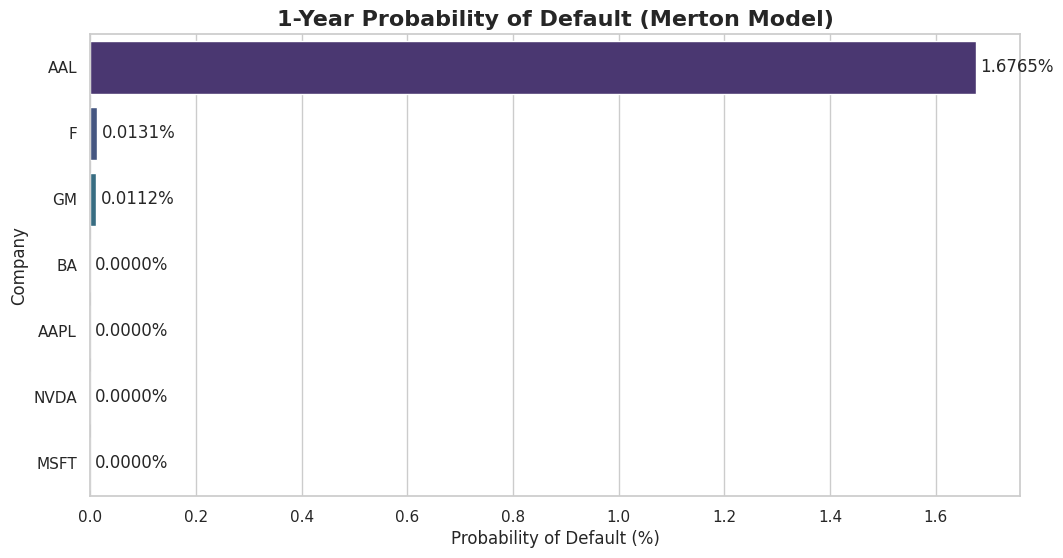

In [7]:
# Set the visual style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

# Create Bar Plot
ax = sns.barplot(
    x='Prob_Default_%',
    y='Ticker',
    data=df,
    palette='viridis'
)

# Add title and labels
plt.title('1-Year Probability of Default (Merton Model)', fontsize=16, fontweight='bold')
plt.xlabel('Probability of Default (%)', fontsize=12)
plt.ylabel('Company', fontsize=12)

# Add value labels to the end of the bars
for i in ax.containers:
    ax.bar_label(i, fmt='%.4f%%', padding=3)

plt.show()

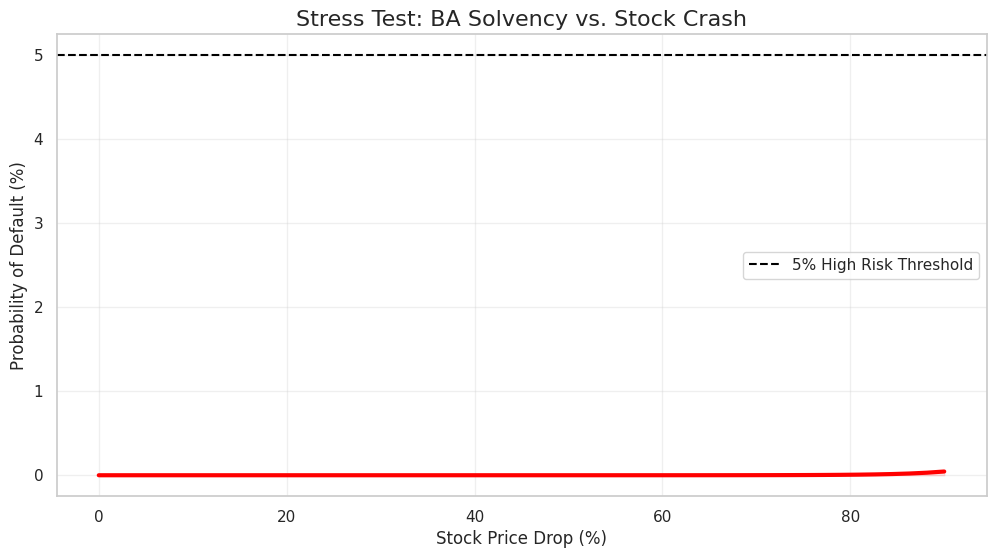

In [8]:
import numpy as np
from src.merton_model import MarketDataProvider, MertonSolver

def run_stress_test(ticker, price_drops):
    """Recalculates PD for simulated stock price crashes."""

    # 1. Get Base Data
    provider = MarketDataProvider(ticker)
    E_base, sigma_E = provider.get_equity_data()
    D = provider.get_debt_structure()
    r = provider.get_risk_free_rate()

    stress_data = []

    # 2. Simulate Crashes
    for drop in price_drops:
        # Simulate Equity Value dropping by x%
        E_stressed = E_base * (1 - drop)

        # Solve Merton for new Equity value
        solver = MertonSolver(E_stressed, sigma_E, D, r)
        res = solver.run()

        if res:
            stress_data.append({
                'Drop_Pct': drop * 100,
                'Prob_Default': res['PD'] * 100
            })

    return pd.DataFrame(stress_data)

# --- CONFIGURATION ---
target_stock = "BA" # Let's stress test Boeing
scenarios = np.linspace(0, 0.90, 50) # Simulate 0% to 90% drop

# Run Test
stress_df = run_stress_test(target_stock, scenarios)

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(stress_df['Drop_Pct'], stress_df['Prob_Default'], color='red', linewidth=3)
plt.fill_between(stress_df['Drop_Pct'], stress_df['Prob_Default'], color='red', alpha=0.1)

# Add "Danger Zone" line
plt.axhline(y=5.0, color='black', linestyle='--', label='5% High Risk Threshold')

plt.title(f"Stress Test: {target_stock} Solvency vs. Stock Crash", fontsize=16)
plt.xlabel("Stock Price Drop (%)", fontsize=12)
plt.ylabel("Probability of Default (%)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()